# Clustering & Geodemographics

A common challenge in data analysis is how to group observations in a data set together in a way that allows for generalisation: _this_ group of observations are similar to one another, _that_ group is dissimilar to this group. But what defines similarity and difference? There is no _one_ answer to that question and so there are many different ways to cluster data, each of which has strengths and weaknesses that make them more, or less, appropriate in different contexts.

## Clustering in Python

The most commonly-used _aspatial_ clustering algorighms are all found in [scikit-learn](http://scikit-learn.org/stable/), so that will be the focus of this practical. But just as there are aspatial and spatial statistics, there are also _spatially-aware_ clustering algorithms to be found in [PySAL](http://pysal.readthedocs.io/en/latest/), the Python Spatial Analysis Library.

### Clustering in sklearn

One organisation recently produced a handy scikit-learn cheatsheet that you should [download](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf). The terminology used in scikit-learn is rather different from anything you will have encountered before (unless you've studied computer science and, possibly, statistics) so it's worth spending a few minutes mapping what you already know on to the sklearn framework:

  | Continuous | Categorical
- | ---------- | -----------
**Supervised** | Regression | Classification
**Unsupervised** | Dimensionality Reduction | Clustering

So clustering is a form of unsupervised (because we don't train the model on what a 'good' result looks like) and categorical (because we get labels out of the model, not predictors) machine learning. Clustering is often used together with PCI (Principal Components Analysis) which is a form of unsupervised dimensionality reduction: data sets with "high dimensionality" are reduced using PCI (you can think of this as a realignment of the axes with the 'data cloud') which has the effect of _maximising the variance_ on each new axis, and the reduced-dimension dataset is then fed to a clustering algorithm. Similarly, supervised approaches are often paired: logistic regression (supervised) is often used with classification (supervised).

Anyway, here's a map to sklearn's algorithms and how to navigate them:

<a href="http://scikit-learn.org/stable/tutorial/machine_learning_map/"><img alt="SciKit-Learn Algorithm Map" src="http://scikit-learn.org/stable/_static/ml_map.png"></a>

### Clustering in PySAL

PySAL is similarly complex and _also_ has a map to help you navigate its complexities -- in this case we're particularly interested in the orange 'branch' of PySAL (labelled clustering!):

![PySAL Map](http://darribas.org/gds_scipy16/content/figs/pysal.png)

### Which Approach is Right?

The reason that there is no 'right' approach (as I said above) is that it all depends on what you're trying to accomplish and how you're _reasoning_ about your problem. The image below highlights the extent to which the different clustering approaches in sklearn can produce different results -- and this is only for the _non-geographic_ algorithms!

<a href="http://scikit-learn.org/stable/modules/clustering.html#clustering"><img alt="Clustering algorithm comparison" src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png" /></a>

To think about this in a little more detail:

* If I run an online company and I want to classify my customers on the basis of their product purchases, then I probably don't care much about where they are, only about what they buy. So my clustering approach doesn't need to take geography into account. I might well _discover_ that many of my most valuable customers live in a few areas, but that is a finding, not a factor, in my research.
* Conversely, if I am looking for cancer clusters then I might well care a _lot_ about geography because I want to make sure that I don't overlook a bigger cluster because it's 'hidden' inside an area with lots of non-sufferers. In that case, I want my clusters to take geography into account because I'm looking for agglomerations. That approach might classify an area with a smaller proportion of cancer patients as part of a 'cancer cluster' but that's because it is still significant _because_ of the geography.

So you can undertake a spatial analysis using _either_ approach, it just depends on the role that you think geography should play in producing the clusters in the first place. We'll see this in action today!

## Obtaining Geodemographic Data

For the sake of simplicity we're going to work with roughly the same set of data for London that Alexiou & Singleton used in their _Geodemographic Analysis_ chapter from [Geocomputation: A Practical Primer](https://uk.sagepub.com/en-gb/eur/geocomputation/book241023). Although the implementation in the _Primer_ is in the R programming language, the concerns and the approach are exactly the same.

### NomisWeb

In case you've forgotten, nearly the _entire_ Census is available to download from [InFuse](http://infuse2011.ukdataservice.ac.uk/), but you can often download data 'in bulk' from [NomisWeb](https://www.nomisweb.co.uk/home/detailedstats.asp?resume=no) directly. 

#### Demographic Data

The tables we want are:
* KS102EW: Age structure
* KS201EW: Ethnic group
* KS401EW: Dwellings, household space and accommodation type
* KS402EW: Tenure
* KS403EW: Rooms, bedrooms and central heating
* KS404EW: Car or van availability
* KS501EW: Qualifications and students
* KS603EW: Economic Activity by Sex

To save you the trouble of manually selecting and downloading each table I have assembled everything into a 'Census.zip' file.

#### Geographic Areas

We want London LSOAs, which you can get by specifying 'Select areas within', then '2011 - super output areas - lower layers', and 'region' (leading to London). 

### ONS Boundary Data

Now we need to download the LSOA boundary data. A quick Google search on "2011 LSOA boundaries" will lead you to the [Data.gov.uk portal](https://data.gov.uk/dataset/lower_layer_super_output_area_lsoa_boundaries). The rest is fairly straightforward:
* We want 'generalised' because that means that they've removed some of the detail from the boundaries so the file will load (and render) more quickly.
* We want 'clipped' because that means that the boundaries have been clipped to the edges of the land (e.g. the Thames; the 'Full' data set splits the Thames down the middle between adjacent LSOAs).

**_Note:_** be sure that you select the **2011** data, not the **2001** data.

### Setup

You should drag both the LSOA boundary file and the Census zipfile into a 'data' directory that is the same directory as this notebook so that they're easy to access. You should then:
* Unzip _only_ the LSOA zipfile.
* Rename the directory containing LSOA data to 'lsoa'.

And we're ready to go!

### Other Sources of Data

If you're more interested in US Census data then there's a nice-looking (I haven't used it) [wrapper to the Census API](https://pypi.python.org/pypi/census).

## Getting to Work

To get started we're going to work with pandas and geopandas -- again, nothing new so far but you'll see we've got some new libraries here.

### Specifying the Kernel

**_Note:_** Before you go any further, we need to check that you've got the right 'Kernel' (virutal environment) specified in Jupyter. At top right it should say "Python [spats]" and that is the environment that we want to work in: spats is short Spatial Analysis and that contains all of the libraries that we need for our research. There are other kernels configured and these can be accessed by clicking on the 'Kernel' menu item and then 'Change Kernel'. This feature is well beyond the scope of this practical, but it basically allows you to run multiple 'versions' of Python with different libraries or versions of libraries installed at the same time.

### Importing the Libraries

In [1]:
import pysal as ps
import pandas as pd
import geopandas as gpd
import seaborn as sns
import clusterpy as cpy
import os
import re
import numpy as np
import zipfile

import random
random.seed(123456789) # For reproducibility

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Make sure output is into notebook
%matplotlib inline

ClusterPy: Library of spatially constrained clustering algorithms


### Loading the Geodata

Unlike the NS-SeC data this is fairly straightforward using geopandas:

In [2]:
gdf = gpd.read_file(os.path.join('data','lsoa','Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp'))
print("Shape of LSOA file: {0} rows by {1} columns".format(gdf.shape[0], gdf.shape[1]))
gdf.head(2)

Shape of LSOA file: 34753 rows by 7 columns


,geometry,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths
0,"POLYGON ((532106.8939689073 182011.4758723566,...",E01000001,City of London 001A,City of London 001A,1,"133,320.77","2,291.85"
1,"POLYGON ((532748.6236845022 181787.1247154782,...",E01000002,City of London 001B,City of London 001B,2,"226,191.27","2,433.96"


### Loading the Census Data

You may need to make a few adjustments to the path to get the data loaded on your own computer. But notice what we're now able to do here: using the `zipfile` library we can extract a data file (or any other file) from the Zip archive without even having to open it. Saves even more time _and_ disk space!

In [3]:
z = zipfile.ZipFile(os.path.join('data','Census.zip'))
z.namelist()

['148410511-Dwellings.csv',
 '2596417429-Age.csv',
 '2653932334-Ethnicity.csv',
 '2735213988-Rooms.csv',
 '2790216173-Vehicles.csv',
 '2874717391-Tenure.csv',
 '3248615150-Qualifications.csv',
 '99521530-Activity.csv']

In [4]:
import re 

# We're going to save each data set to a
# separate data frame to make it easier
# to work with during cleaning
d = {}

for r in range(0, len(z.namelist())):
    
    m  = re.search("(?:-)([^\.]+)", z.namelist()[r])
    nm = m.group(1)
    
    print("Processing {0} file: ".format(nm))
    
    if z.namelist()[r] == '99521530-Activity.csv':
        d[nm] = pd.read_csv(z.open(z.namelist()[r]), header=7, skip_blank_lines=True, skipfooter=7, engine='python')
    else: 
        pass
        d[nm] = pd.read_csv(z.open(z.namelist()[r]), header=6, skip_blank_lines=True, skipfooter=7, engine='python')
    
    print("\tShape of dataframe is {0} rows by {1} columns".format(d[nm].shape[0], d[nm].shape[1]))


Processing Dwellings file: 
	Shape of dataframe is 4835 rows by 14 columns
Processing Age file: 
	Shape of dataframe is 4835 rows by 19 columns
Processing Ethnicity file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Rooms file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Vehicles file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Tenure file: 
	Shape of dataframe is 4835 rows by 8 columns
Processing Qualifications file: 
	Shape of dataframe is 4835 rows by 10 columns
Processing Activity file: 
	Shape of dataframe is 4835 rows by 11 columns


## Tidying Up

OK, that's a _lot_ of data! 4,835 rows and 88 columns. However, we don't know how much of this is redundant and so need to work out what might need removing from the data set before we can try clustering. So we're going to work our way through each data set in turn so that we can convert them to percentages before combining them into a single, large data set.

### Dwellings

From dewllings we're mainly interested in the housing type since we would expect that housing typologies will be a determinant of the types of people who live in an area. We _could_ look at places with no usual residents as well, or explore the distribution of shared dwellings, but this is a pretty good start.

In [5]:
t = 'Dwellings'

# If we find this column, this deletes it
if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

# List all of the columns    
d[t].columns

Index([u'mnemonic', u'Unshared dwelling',
       u'Shared dwelling: Two household spaces',
       u'Shared dwelling: Three or more household spaces',
       u'Household spaces with at least one usual resident',
       u'Household spaces with no usual residents',
       u'Whole house or bungalow: Detached',
       u'Whole house or bungalow: Semi-detached',
       u'Whole house or bungalow: Terraced (including end-terrace)',
       u'Flat, maisonette or apartment: Purpose-built block of flats or tenement',
       u'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)',
       u'Flat, maisonette or apartment: In a commercial building',
       u'Caravan or other mobile or temporary structure'],
      dtype='object')

In [6]:
# Select the columns we're interested in analysing
selection = [u'Whole house or bungalow: Detached', u'Whole house or bungalow: Semi-detached',
       u'Whole house or bungalow: Terraced (including end-terrace)',
       u'Flat, maisonette or apartment: Purpose-built block of flats or tenement',
       u'Flat, maisonette or apartment: Part of a converted or shared house (including bed-sits)',
       u'Flat, maisonette or apartment: In a commercial building',
       u'Caravan or other mobile or temporary structure']

# We can't be sure how the totals add up 
# so it's best to generate our own based
# on the selection
d[t]['Total Properties'] = d[t].ix[:, selection].sum(axis=1)

In [7]:
# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    m  = re.search("^(?:[^\:]*)(?:\:\s)?(.+)$", c)
    nm = m.group(1)
    if nm == 'e':
        nm = 'Caravan'
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['Total Properties'].astype(float))

In [9]:
d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,Detached,Semi-detached,Terraced (including end-terrace),Purpose-built block of flats or tenement,Part of a converted or shared house (including bed-sits),In a commercial building,Caravan
2410,E01000626,0.05,0.16,0.28,0.42,0.09,0.00,0.00
1212,E01003622,0.07,0.09,0.32,0.42,0.05,0.05,0.00
2133,E01000260,0.06,0.43,0.18,0.25,0.07,0.01,0.00
1977,E01000056,0.04,0.15,0.64,0.16,0.02,0.00,0.00
933,E01003145,0.04,0.13,0.11,0.16,0.53,0.04,0.00


### Age

In [10]:
t = 'Age'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

d[t].columns

Index([u'mnemonic', u'All usual residents', u'Age 0 to 4', u'Age 5 to 7',
       u'Age 8 to 9', u'Age 10 to 14', u'Age 15', u'Age 16 to 17',
       u'Age 18 to 19', u'Age 20 to 24', u'Age 25 to 29', u'Age 30 to 44',
       u'Age 45 to 59', u'Age 60 to 64', u'Age 65 to 74', u'Age 75 to 84',
       u'Age 85 to 89', u'Age 90 and over'],
      dtype='object')

In [11]:
# Derived columns
d[t]['Age 5 to 14']  = d[t]['Age 5 to 7'] + d[t]['Age 8 to 9'] + d[t]['Age 10 to 14'] 
d[t]['Age 15 to 24'] = d[t]['Age 15'] + d[t]['Age 16 to 17'] + d[t]['Age 18 to 19'] + d[t]['Age 20 to 24']
d[t]['Age 25 to 44'] = d[t]['Age 25 to 29'] + d[t]['Age 30 to 44']
d[t]['Age 45 to 64'] = d[t]['Age 45 to 59'] + d[t]['Age 60 to 64']
d[t]['Age 65+'] = d[t]['Age 65 to 74'] + d[t]['Age 75 to 84'] + d[t]['Age 85 to 89'] + d[t]['Age 90 and over']

# Select the columns we're interested in analysing
selection = ['Age 0 to 4','Age 5 to 14','Age 15 to 24',
             'Age 25 to 44','Age 45 to 64','Age 65+']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,Age 0 to 4,Age 5 to 14,Age 15 to 24,Age 25 to 44,Age 45 to 64,Age 65+
3675,E01002337,0.04,0.10,0.11,0.19,0.31,0.25
3304,E01001528,0.07,0.13,0.17,0.32,0.23,0.07
3353,E01033736,0.06,0.04,0.11,0.66,0.11,0.01
2593,E01000772,0.05,0.09,0.08,0.22,0.27,0.29
333,E01001870,0.04,0.04,0.16,0.56,0.15,0.05


### Ethnicity

In [12]:
t = 'Ethnicity'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

d[t].columns

Index([u'mnemonic', u'All usual residents', u'White',
       u'Mixed/multiple ethnic groups', u'Asian/Asian British',
       u'Black/African/Caribbean/Black British', u'Other ethnic group'],
      dtype='object')

In [13]:
# Select the columns we're interested in analysing
selection = ['White', 'Mixed/multiple ethnic groups', 'Asian/Asian British', 
             'Black/African/Caribbean/Black British', 'Other ethnic group']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,White,Mixed/multiple ethnic groups,Asian/Asian British,Black/African/Caribbean/Black British,Other ethnic group
1683,E01004502,0.83,0.05,0.09,0.02,0.01
3297,E01001463,0.51,0.05,0.18,0.19,0.07
1944,E01000070,0.42,0.06,0.43,0.08,0.01
1096,E01003328,0.63,0.07,0.07,0.21,0.03
4327,E01003672,0.67,0.07,0.15,0.08,0.02


### Rooms

In [14]:
t = 'Rooms'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

d[t].columns

Index([u'mnemonic', u'All categories: Type of central heating in household',
       u'Does not have central heating', u'Does have central heating',
       u'Occupancy rating (rooms) of -1 or less',
       u'Occupancy rating (bedrooms) of -1 or less', u'Average household size',
       u'Average number of rooms per household',
       u'Average number of bedrooms per household'],
      dtype='object')

In [15]:
# Select the columns we're interested in analysing
selection = ['Does not have central heating', 'Occupancy rating (bedrooms) of -1 or less', 
             'Average household size', 'Average number of rooms per household']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
c = 'Does not have central heating'
d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Type of central heating in household'].astype(float))

c = 'Occupancy rating (bedrooms) of -1 or less'
d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Type of central heating in household'].astype(float))

c = 'Average household size'
d_pct[c] = pd.Series(d[t][c].astype(float))

c = 'Average number of rooms per household'
d_pct[c] = pd.Series(d[t][c].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,Does not have central heating,Occupancy rating (bedrooms) of -1 or less,Average household size,Average number of rooms per household
3438,E01001617,0.02,0.04,2.10,5.10
3473,E01001662,0.03,0.06,2.20,4.60
1638,E01004506,0.03,0.06,2.00,4.20
446,E01001996,0.07,0.05,2.30,4.90
2671,E01000791,0.01,0.02,2.30,5.60


### Vehicles

In [16]:
t = 'Vehicles'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

d[t].columns

Index([u'mnemonic', u'All categories: Car or van availability',
       u'No cars or vans in household', u'1 car or van in household',
       u'2 cars or vans in household', u'3 cars or vans in household',
       u'4 or more cars or vans in household'],
      dtype='object')

In [17]:
# Select the columns we're interested in analysing
selection = [u'No cars or vans in household', u'1 car or van in household',
       u'2 cars or vans in household', u'3 cars or vans in household',
       u'4 or more cars or vans in household']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Car or van availability'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,No cars or vans in household,1 car or van in household,2 cars or vans in household,3 cars or vans in household,4 or more cars or vans in household
3023,E01001210,0.53,0.35,0.11,0.01,0.00
2132,E01000259,0.17,0.51,0.26,0.06,0.01
945,E01003244,0.66,0.30,0.03,0.00,0.00
1008,E01003231,0.49,0.42,0.08,0.01,0.00
3354,E01033737,0.62,0.33,0.04,0.00,0.00


### Tenure

In [18]:
t = 'Tenure'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

d[t].columns

Index([u'mnemonic', u'All households', u'Owned',
       u'Shared ownership (part owned and part rented)', u'Social rented',
       u'Private rented', u'Living rent free'],
      dtype='object')

In [19]:
# Select the columns we're interested in analysing
selection = [u'Owned', u'Shared ownership (part owned and part rented)', 
             u'Social rented', u'Private rented', u'Living rent free']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All households'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,Owned,Shared ownership (part owned and part rented),Social rented,Private rented,Living rent free
3512,E01002122,0.71,0.00,0.03,0.25,0.02
456,E01001991,0.39,0.00,0.07,0.54,0.01
4551,E01003831,0.76,0.02,0.07,0.15,0.01
4583,E01004135,0.86,0.01,0.01,0.12,0.00
2425,E01000613,0.37,0.01,0.17,0.45,0.01


### Qualifications

In [20]:
t = 'Qualifications'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

d[t].columns

Index([u'mnemonic', u'All categories: Highest level of qualification',
       u'No qualifications',
       u'Highest level of qualification: Level 1 qualifications',
       u'Highest level of qualification: Level 2 qualifications',
       u'Highest level of qualification: Apprenticeship',
       u'Highest level of qualification: Level 3 qualifications',
       u'Highest level of qualification: Level 4 qualifications and above',
       u'Highest level of qualification: Other qualifications'],
      dtype='object')

In [21]:
# Select the columns we're interested in analysing
selection = [u'No qualifications',
       u'Highest level of qualification: Level 1 qualifications',
       u'Highest level of qualification: Level 2 qualifications',
       u'Highest level of qualification: Apprenticeship',
       u'Highest level of qualification: Level 3 qualifications',
       u'Highest level of qualification: Level 4 qualifications and above',
       u'Highest level of qualification: Other qualifications']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    d_pct[c] = pd.Series(d[t][c].astype(float)/d[t]['All categories: Highest level of qualification'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,No qualifications,Highest level of qualification: Level 1 qualifications,Highest level of qualification: Level 2 qualifications,Highest level of qualification: Apprenticeship,Highest level of qualification: Level 3 qualifications,Highest level of qualification: Level 4 qualifications and above,Highest level of qualification: Other qualifications
700,E01002826,0.05,0.04,0.06,0.01,0.09,0.62,0.14
866,E01003024,0.19,0.11,0.12,0.01,0.10,0.34,0.14
3350,E01033731,0.05,0.09,0.11,0.00,0.11,0.55,0.09
3985,E01002583,0.17,0.11,0.12,0.02,0.09,0.31,0.18
1119,E01003581,0.23,0.16,0.13,0.01,0.09,0.22,0.16


### Activity

In [22]:
t = 'Activity'

if np.where(d[t].columns.values=='2011 super output area - lower layer')[0] >= 0:
    d[t] = d[t].drop('2011 super output area - lower layer', 1)

d[t].columns

Index([u'mnemonic', u'All usual residents aged 16 to 74',
       u'Economically active: In employment',
       u'Economically active: Unemployed',
       u'Economically active: Full-time student',
       u'Economically inactive: Retired',
       u'Economically inactive: Student (including full-time students)',
       u'Economically inactive: Looking after home or family',
       u'Economically inactive: Long-term sick or disabled',
       u'Economically inactive: Other'],
      dtype='object')

In [23]:
# Select the columns we're interested in analysing
selection = [u'Economically active: In employment',
       u'Economically active: Unemployed',
       u'Economically active: Full-time student',
       u'Economically inactive: Retired',
       u'Economically inactive: Student (including full-time students)',
       u'Economically inactive: Looking after home or family',
       u'Economically inactive: Long-term sick or disabled',
       u'Economically inactive: Other']

# Create a new data frame to 
# hold the percentage values
# and initialise it with only
# the 'mnemonic' (i.e. GeoCode)
d_pct = pd.concat(
    [d[t]['mnemonic']], 
    axis=1, 
    keys=['mnemonic'])

# For each of the columns remaining
# in the select
for c in selection:
    m = re.search("^Eco.*?active: (.+)$", c)
    nm = m.group(1)
    d_pct[nm] = pd.Series(d[t][c].astype(float)/d[t]['All usual residents aged 16 to 74'].astype(float))

d[t + '_pct'] = d_pct
d[t + '_pct'].sample(5)

,mnemonic,In employment,Unemployed,Full-time student,Retired,Student (including full-time students),Looking after home or family,Long-term sick or disabled,Other
988,E01003345,0.67,0.04,0.05,0.05,0.08,0.04,0.03,0.04
3788,E01002480,0.68,0.03,0.02,0.15,0.06,0.04,0.01,0.01
2193,E01000145,0.60,0.05,0.03,0.07,0.11,0.09,0.01,0.04
900,E01003066,0.61,0.06,0.04,0.07,0.08,0.04,0.04,0.05
2799,E01001004,0.60,0.06,0.06,0.04,0.09,0.07,0.04,0.05


## Bringing it All Together

Now that we've standardised everything using percentages, it's time to bring the data together! We'll initialise the data frame using the first matching data set, and then iterate over the rest, merging the data frames as we go.

In [29]:
matching = [s for s in d.keys() if "_pct" in s]

lsoac = d[matching[0]]

for m in range(1, len(matching)):
    lsoac = lsoac.merge(d[matching[m]], how='inner', left_on='mnemonic', right_on='mnemonic')

In [31]:
lsoac.columns

Index([                                                        u'mnemonic',
                                          u'Does not have central heating',
                              u'Occupancy rating (bedrooms) of -1 or less',
                                                 u'Average household size',
                                  u'Average number of rooms per household',
                                                                  u'Owned',
                          u'Shared ownership (part owned and part rented)',
                                                          u'Social rented',
                                                         u'Private rented',
                                                       u'Living rent free',
                                           u'No cars or vans in household',
                                              u'1 car or van in household',
                                            u'2 cars or vans in household',
            

In [33]:
print("Shape of full data frame is {0} by {1}".format(lsoac.shape[0], lsoac.shape[1]))

Shape of full data frame is 4835 by 48


## Removing Badly-Behaved Variables

Some of these variables will be very difficult to work with because they are so strongly skewed. We can test the degree to which this is a problem fairly easily in pandas:

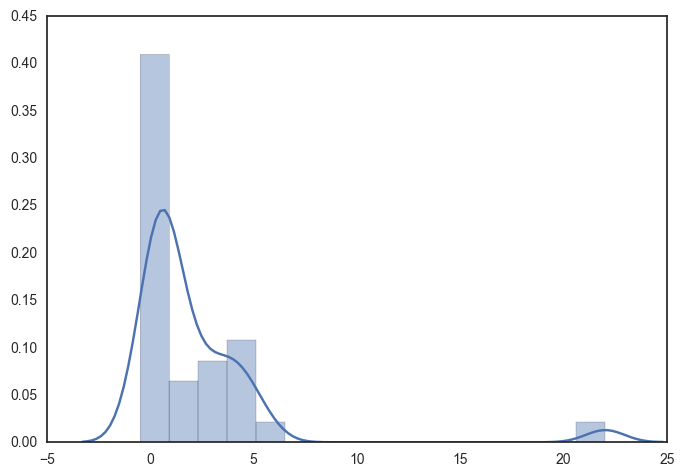

In [224]:
sns.distplot(lsoac.skew(axis=0, numeric_only=True).values)

In [230]:
sk = lsoac.skew(axis=0, numeric_only=True)
to_drop = sk[sk >= 4].index
print(to_drop.values)

[u'Shared ownership (part owned and part rented)' u'Living rent free'
 u'Highest level of qualification: Level 3 qualifications' 'Caravan'
 u'Student (including full-time students)' u'Other']


In [232]:
lsoac.drop(to_drop.values, axis=1, inplace=True)

## Removing Correlated Variables

In [233]:
lsoac.corr()

,Does not have central heating,Occupancy rating (bedrooms) of -1 or less,Average household size,Average number of rooms per household,Owned,Social rented,Private rented,1 car or van in household,White,Mixed/multiple ethnic groups,...,Terraced (including end-terrace),Purpose-built block of flats or tenement,Part of a converted or shared house (including bed-sits),In a commercial building,Age 0 to 4,Age 15 to 24,Age 25 to 44,In employment,Full-time student,Looking after home or family
Does not have central heating,1.00,0.10,-0.36,-0.44,-0.28,-0.03,0.52,-0.14,-0.01,0.21,...,-0.02,0.24,0.26,0.27,0.03,0.03,0.46,0.14,0.03,-0.15
Occupancy rating (bedrooms) of -1 or less,0.10,1.00,0.39,-0.54,-0.67,0.54,0.29,-0.43,-0.82,0.33,...,0.04,0.36,0.03,0.06,0.40,0.42,0.24,-0.63,0.62,0.45
Average household size,-0.36,0.39,1.00,0.46,0.28,-0.12,-0.27,0.18,-0.53,-0.25,...,0.38,-0.46,-0.33,-0.17,0.25,0.24,-0.43,-0.40,0.38,0.50
Average number of rooms per household,-0.44,-0.54,0.46,1.00,0.86,-0.59,-0.51,0.46,0.31,-0.48,...,0.18,-0.72,-0.26,-0.20,-0.22,-0.21,-0.66,0.20,-0.24,0.02
Owned,-0.28,-0.67,0.28,0.86,1.00,-0.81,-0.42,0.62,0.44,-0.55,...,0.26,-0.76,-0.24,-0.15,-0.27,-0.32,-0.53,0.42,-0.34,-0.20
Social rented,-0.03,0.54,-0.12,-0.59,-0.81,1.00,-0.19,-0.53,-0.34,0.46,...,-0.17,0.62,-0.07,-0.09,0.27,0.31,0.06,-0.59,0.29,0.29
Private rented,0.52,0.29,-0.27,-0.51,-0.42,-0.19,1.00,-0.22,-0.19,0.21,...,-0.16,0.28,0.54,0.40,0.02,0.05,0.79,0.21,0.13,-0.13
1 car or van in household,-0.14,-0.43,0.18,0.46,0.62,-0.53,-0.22,1.00,0.32,-0.28,...,0.45,-0.54,-0.15,-0.19,0.19,-0.39,-0.23,0.39,-0.29,-0.02
White,-0.01,-0.82,-0.53,0.31,0.44,-0.34,-0.19,0.32,1.00,-0.28,...,-0.07,-0.23,0.12,0.02,-0.34,-0.39,-0.08,0.62,-0.59,-0.46
Mixed/multiple ethnic groups,0.21,0.33,-0.25,-0.48,-0.55,0.46,0.21,-0.28,-0.28,1.00,...,-0.06,0.35,0.30,0.03,0.25,0.09,0.33,-0.14,0.13,-0.05


In [252]:
from math import fabs 
import numpy as np

corrs    = 0.50
corrh    = 0.70
maxcorrs = 3

corrm = lsoac.corr()
corrm['name'] = corrm.index

num_corrs = []
hi_corrs  = []

for c in corrm.columns:
    if c != 'name':
        hits = corrm.loc[(corrm[c] >= corrs) & (corrm[c] < 1.0), c]
        print("=" * 70)
        print("Strongly correlated with '" + c + "'")
        if hits.size > 0: 
            print(hits.index.values)
            num_corrs.append(hits.size)
            hi_corrs.append(hits[ hits > corrh ].size)

Strongly correlated with 'Does not have central heating'
[u'Private rented']
Strongly correlated with 'Occupancy rating (bedrooms) of -1 or less'
[u'Social rented' 'Asian/Asian British'
 u'Highest level of qualification: Other qualifications'
 u'Full-time student']
Strongly correlated with 'Average household size'
['Asian/Asian British' u'Looking after home or family']
Strongly correlated with 'Average number of rooms per household'
[u'Owned' u'Detached']
Strongly correlated with 'Owned'
['Average number of rooms per household' u'1 car or van in household']
Strongly correlated with 'Social rented'
['Occupancy rating (bedrooms) of -1 or less' u'No qualifications'
 u'Purpose-built block of flats or tenement']
Strongly correlated with 'Private rented'
['Does not have central heating'
 u'Highest level of qualification: Level 4 qualifications and above'
 u'Part of a converted or shared house (including bed-sits)' 'Age 25 to 44']
Strongly correlated with '1 car or van in household'
[u'Owned'

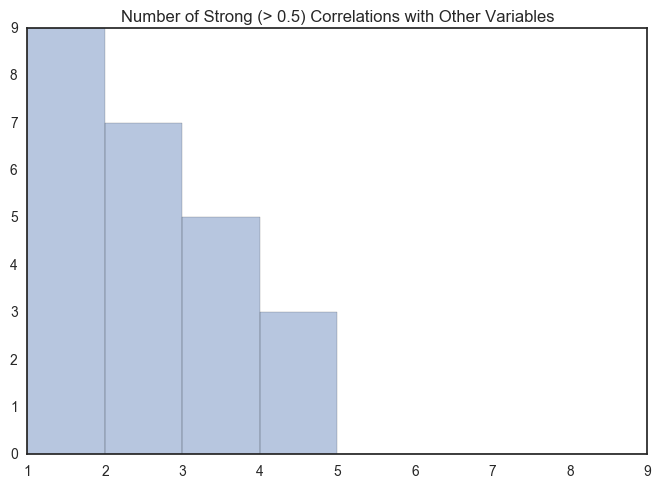

In [253]:
sns.distplot(num_corrs, bins=range(1,10), kde=False).set_title("Number of Strong (> " + str(corrs) + ") Correlations with Other Variables")

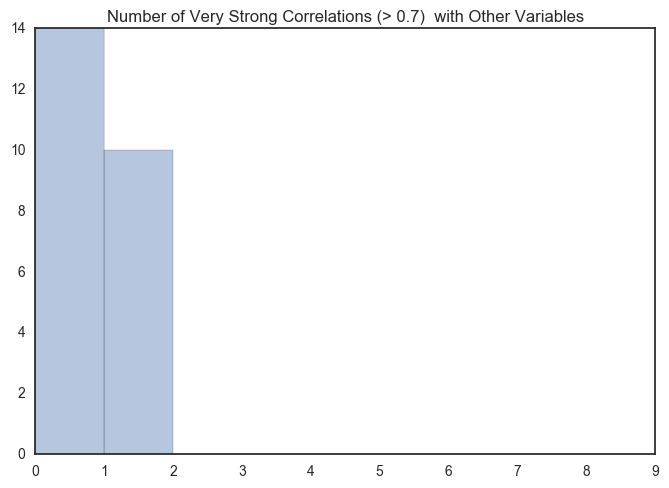

In [254]:
sns.distplot(hi_corrs, bins=range(0,10), kde=False).set_title("Number of Very Strong Correlations (> " + str(corrh) + ")  with Other Variables")

### Stripping Out 'Redundant' Variables

Let's remove any variable that has either:
1. A *lot* of correlations in excess of 0.50.
2. A correlation higher than 0.70 with at least one other variable.

This will reduce the dimensionality of our data and allow us to then focus on normalisation.

In [278]:
list(hits[ hits > corrh ].index.values)

[]

In [280]:
to_drop = []
to_keep = []

for c in corrm.columns:
    if c != 'name':
        
        hits = corrm.loc[(corrm[c] >= corrs) & (corrm[c] < 1.0), c]
        
        print("=" * 12 + " " + c + " " + "=" * 12)
        print(hits)
        
        hi_vals    = False
        multi_vals = False
        
        # Remove ones with very high correlations
        if hits[ hits > corrh ].size > 0:
            #print(">>> Very high correlation...")
            s1 = set(to_keep)
            s2 = set(hits[ hits > corrh ].index.values)
            #print("Comparing to_keep(" + ", ".join(s1) + ") to hits(" + ", ".join(s2) + ")")
            s1 &= s2
            #print("Column found in 'very high correlations': " + str(s1))
            if len(s1) > 1: 
                hi_vals = True
                print("Will drop '" + c + "' because of high correlation with: \n\t" + "\n\t".join(s1))
            else:
                
                to_drop = to_drop + list(hits[ hits > corrh ].index.values)
                print("Will drop " + str(set(hits[ hits > corrh ].index.values)))
        
        # Remove ones with many correlations
        if hits.size >= 4: 
            print(">>> Many correlations...")
            s1 = set(to_keep)
            s2 = set(hits.index.values)
            print("Comparing to_keep(" + ", ".join(s1) + ") to hits(" + ", ".join(s2) + ")")
            s1 &= s2
            #print("Column found in 'many correlations' :" + str(s1))
            if len(s1) > 1: 
                multi_vals = True
                print("Will drop '" + c + "' because of multiple correlations with: \n\t" + "\n\t".join(s1))
        
        if hi_vals==True or multi_vals==True:
            to_drop.append(c)
        else:
            to_keep.append(c)

print(" ")
print("To drop: " + ", ".join(to_drop))
print(" ")
print("To keep: " + ", ".join(to_keep))

============ Does not have central heating ============
Private rented   0.52
Name: Does not have central heating, dtype: float64
============ Occupancy rating (bedrooms) of -1 or less ============
Social rented                                          0.54
Asian/Asian British                                    0.51
Highest level of qualification: Other qualifications   0.73
Full-time student                                      0.62
Name: Occupancy rating (bedrooms) of -1 or less, dtype: float64
Will drop set([u'Highest level of qualification: Other qualifications'])
>>> Many correlations...
Comparing to_keep(Does not have central heating) to hits(Social rented, Full-time student, Highest level of qualification: Other qualifications, Asian/Asian British)
============ Average household size ============
Asian/Asian British            0.63
Looking after home or family   0.50
Name: Average household size, dtype: float64
============ Average number of rooms per household ============
Owne

In [152]:
lsoac.drop(to_drop, axis=1, inplace=True, errors='raise')

## Standardising the Data

The effectiveness of clustering algorithms is usually demonstrated using the 'iris data' -- it's available by default with both Seaborn and SciKit-Learn. This data doesn't usually need normalisation but it's a good way to start looking at the data across four dimensions and seeing how it varies and why some dimensions are 'good' for clustering, while others are 'not useful'...

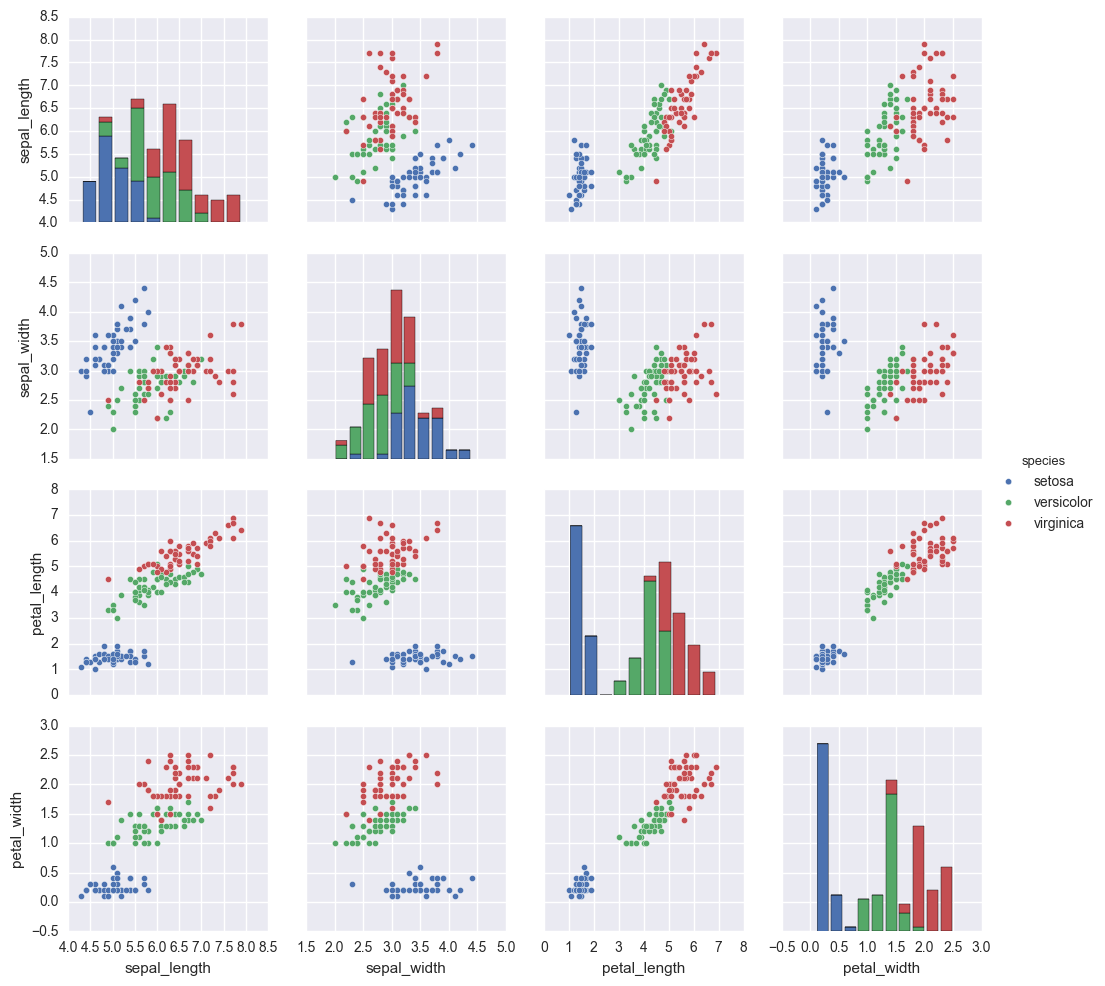

In [151]:
sns.set()
irises = sns.load_dataset("iris")
sns.pairplot(irises, hue="species")

### Why Standardise

One of the main challenges of clustering, however, is that the scale of each dimension matters: if you were to try to cluster, for example, [1] how many metres per year a glacier moved with [2] the number of cubic metres by which it grew, then you would only be clustering on variable [2]. 

That's because glaciers contain millions of cubic metres of ice and will grow or shrink by thousands of cubic metres each year. In contrast, most glaciers move at most a few metres per year. So the sheer scale difference between these two dimensions means that the values of variable 1 dominate the clustering algorithm because they provide a much better 'spread' in the data than variable 2.

To address this we need to standardise the data in some way so that the scales are relatively consistent. There's no _one_ way to standardise the data, it depends on the characteristics of the data _as well as_ what we're looking for in terms of clustering. As a general rule, we're _aiming_ for a normal (a.k.a. Gaussian) distribution with 0 mean and unit variance. The latter part of this is what most people focus on: you may recall our work with transformations last year, and here's one more reason why it's useful. That said, normalisation (making the data 'look' normal) can also be very important for the process since it can significantly skew the results as well if the data itself is heavily skewed.

Right, so does this all sound a little bit familiar from last year? Let's start by just looking at a few variables in a simple scatter plot...

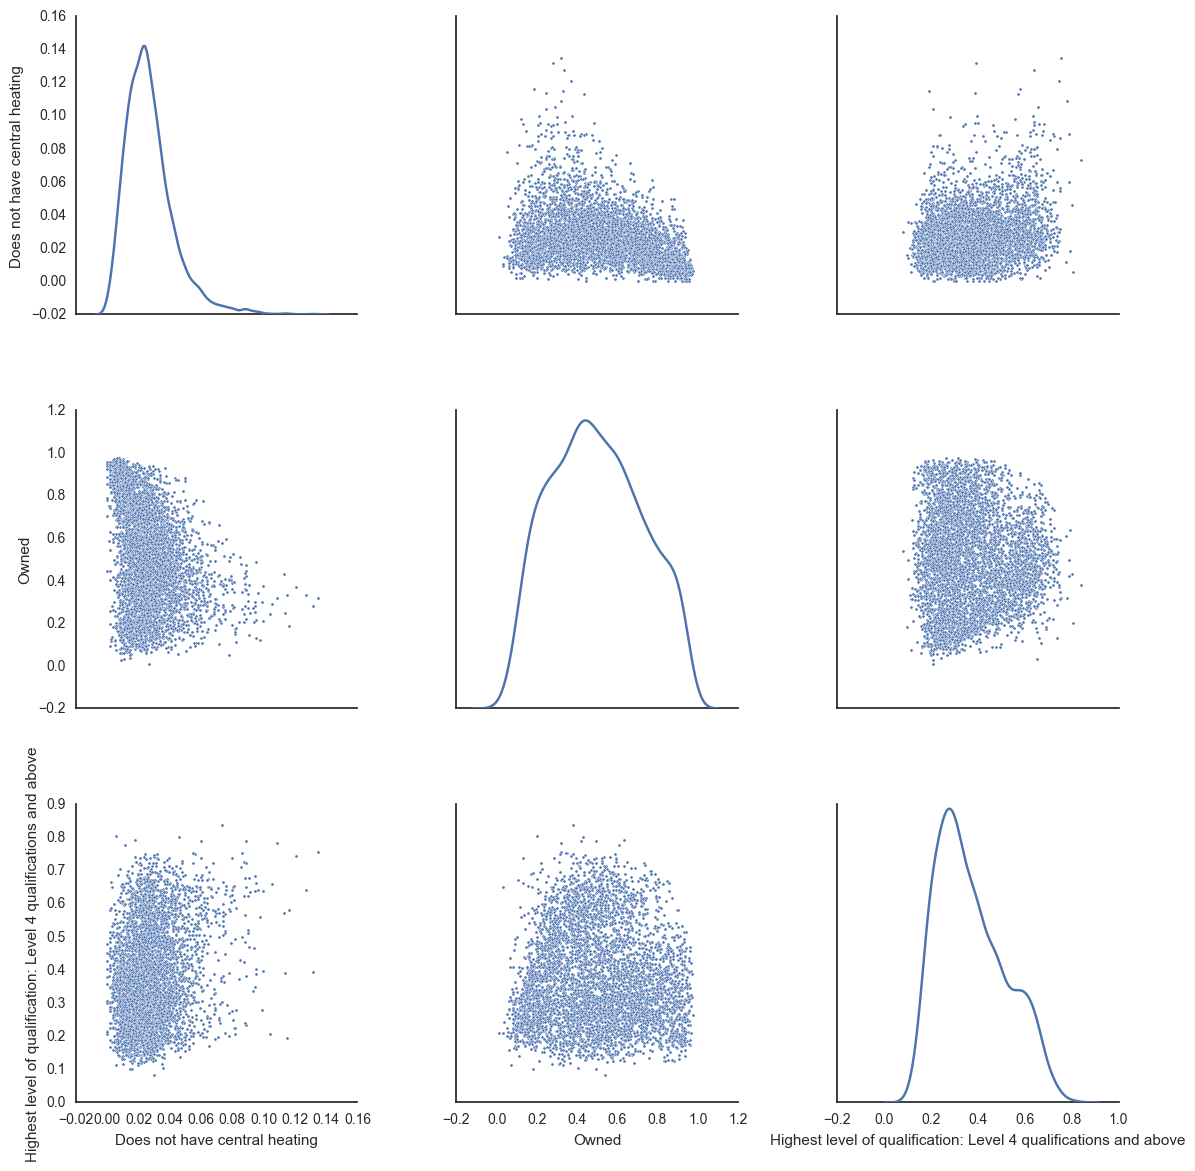

In [282]:
# The data as it is now...
sns.set(style="white")
sns.pairplot(lsoac, 
             vars=['Does not have central heating','Owned','Highest level of qualification: Level 4 qualifications and above'], 
             markers=".", size=4, diag_kind='kde')

So there are clearly some differences, but I'd be hard-pressed to give you sensible clusters just by looking at this data. In particular, we have a _real_ problem with the comparisons since 'No Central Heating' _looks_ like it has a very compressed distribution... If we have this problem of comparing different scales, so does the computer.

### Standardisation with SKLearn

Let's try standardising the data now:

In [283]:
# Here's how we can rescale in a robust way
import sklearn
print("SciKit-Learn verion is: " + sklearn.__version__)
from sklearn import preprocessing

SciKit-Learn verion is: 0.18.1


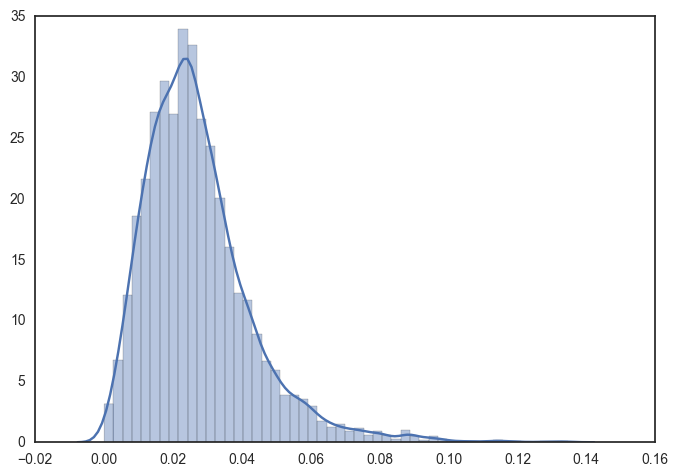

In [284]:
sns.distplot(
    lsoac['Does not have central heating'].values.reshape(-1,1))

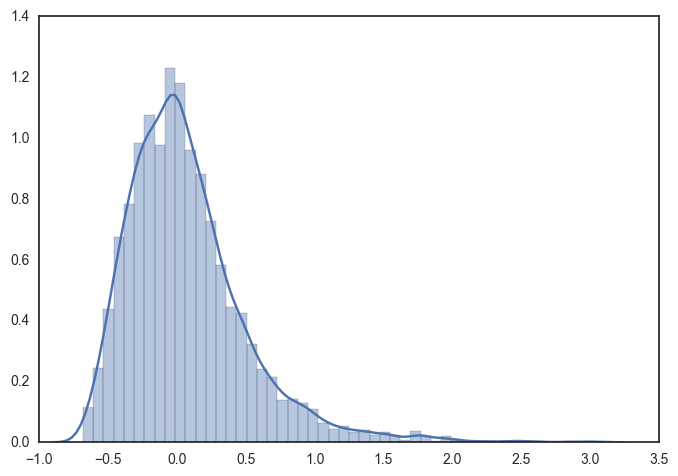

In [285]:
sns.distplot(
    preprocessing.robust_scale(lsoac['Does not have central heating'].values.reshape(-1,1), quantile_range=(10.0, 90.0)))

In [292]:
df = lsoac.copy(deep=True)

#scaler = preprocessing.RobustScaler(quantile_range=[5.0, 95.0])
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

df[to_keep] = scaler.fit_transform(df[to_keep])

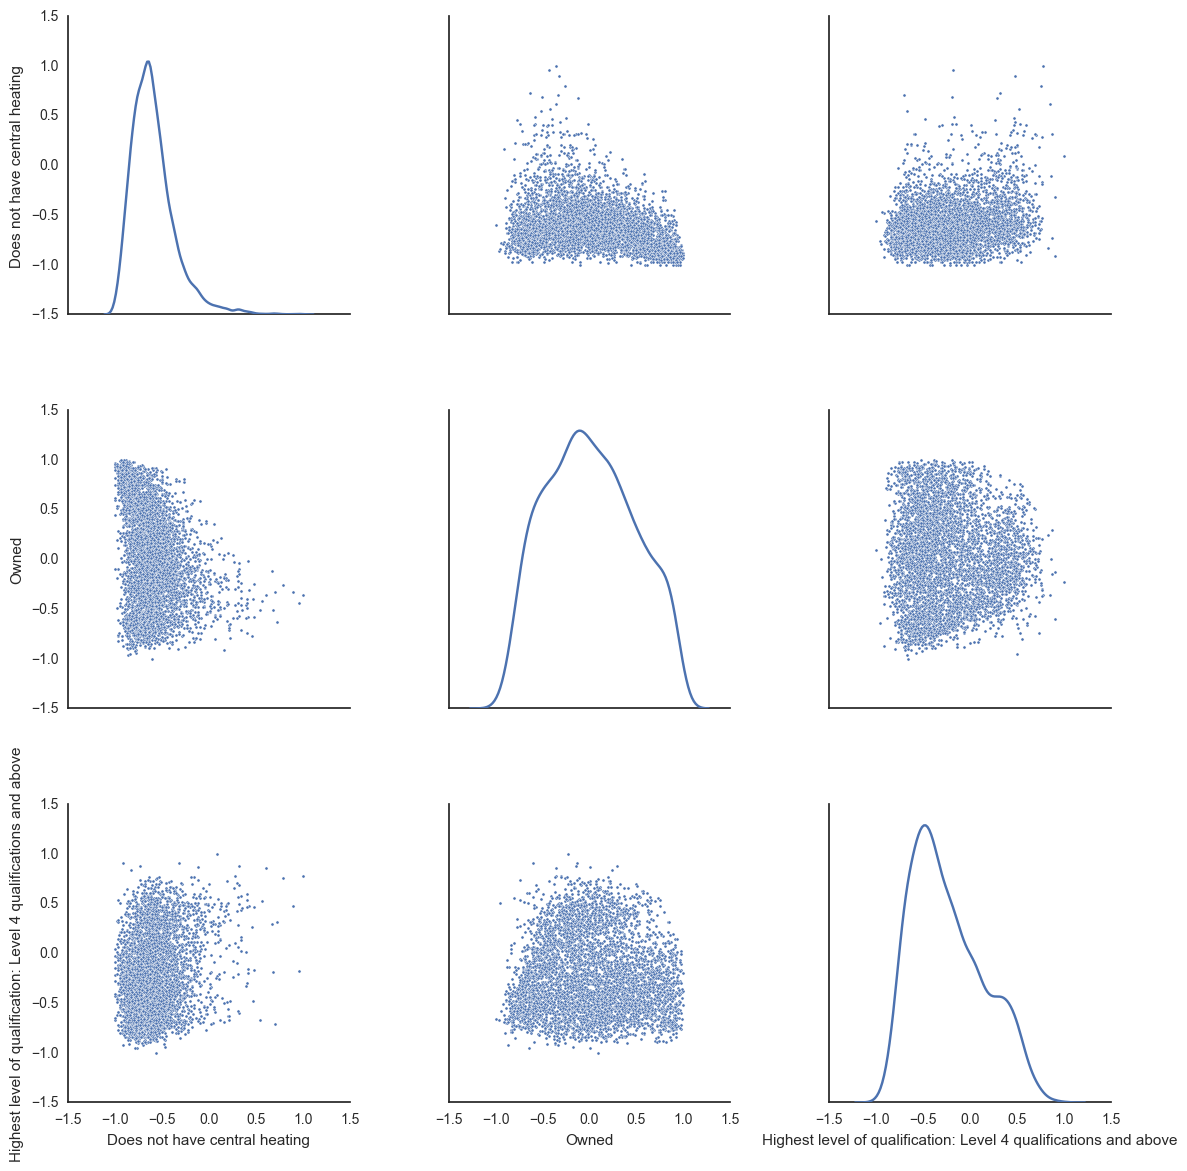

In [287]:
# The data as it is now...
sns.set(style="white")
sns.pairplot(df, 
             vars=['Does not have central heating','Owned','Highest level of qualification: Level 4 qualifications and above'], 
             markers=".", size=4, diag_kind='kde')

Right, so you can see that robustly rescaling the dimension hasn't fundamentally changed the data itself, but it has changed it so that the the data it broadly re-centered on 0 and yet we still have the original outliers from the raw data. You could _also_ do IQR standardisation (0.25 and 0.75) with the percentages, but in those cases you would have _more_ outliers and then _more_ extreme values skewing the results of the clustering algorithm.

In [294]:
# Change the index
df.set_index('mnemonic', drop=True, inplace=True)
df.index.name = None

In [295]:
df.describe()

,Does not have central heating,Occupancy rating (bedrooms) of -1 or less,Average household size,Average number of rooms per household,Owned,Social rented,Private rented,1 car or van in household,White,Mixed/multiple ethnic groups,...,Terraced (including end-terrace),Purpose-built block of flats or tenement,Part of a converted or shared house (including bed-sits),In a commercial building,Age 0 to 4,Age 15 to 24,Age 25 to 44,In employment,Full-time student,Looking after home or family
count,"4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00",...,"4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00","4,835.00"
mean,0.20,0.28,0.41,0.35,0.51,0.26,0.26,0.57,0.60,0.31,...,0.27,0.36,0.16,0.07,0.32,0.15,0.31,0.66,0.14,0.33
std,0.12,0.17,0.14,0.14,0.23,0.22,0.15,0.16,0.22,0.14,...,0.21,0.27,0.19,0.09,0.11,0.07,0.14,0.12,0.08,0.14
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.12,0.14,0.33,0.25,0.32,0.08,0.14,0.46,0.45,0.21,...,0.10,0.14,0.03,0.01,0.25,0.11,0.22,0.58,0.09,0.23
50%,0.18,0.26,0.41,0.34,0.50,0.19,0.24,0.59,0.63,0.31,...,0.22,0.29,0.07,0.03,0.31,0.14,0.29,0.67,0.12,0.31
75%,0.25,0.39,0.48,0.43,0.68,0.40,0.36,0.68,0.78,0.41,...,0.41,0.53,0.23,0.08,0.39,0.17,0.39,0.74,0.17,0.41
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### A Step Too Far?

A last consideration is whether or not we should now fully rescale the data so it all falls into the 0-to-1 range: the standardisation process has given us a better perspective on _where_ high concentrations of different groups might be found, but we still need to decide whether the clustering or other machine learning processes should be influenced by the full range of the data. I lean towards _not_ rescaling on the basis that super-high concentrations of particular groups _should_ have a significant impact on the results of the clustering process, but it does mean that we're more likely to get one large cluster (containing the bulk of the non-extreme data) and a number of small clusters (each containing a small number of 'extreme' LSOAs). 

My point is that it's debatable -- the right choice is the one that you can argue for. There are plenty of researchers who would disagree with me on the paragraph above.

## Normalisation

As you'll have read in the _Gecomputation_ chapter, it's common to normalise the data after standardisation. This raises similar questions to the ones discussed immediately above: do we want more balanced clusters or not? I've not given you code to normalise the data, but you might like to compare the results with and without normalisation after seeing how you can adapt the code block below to work with all of the columns in the data frame.

### Box-Cox Transformations

SciPy gives you the ability to run Box-Cox transformations which try to find the most normal-like distribution that can be produced from your data. Unlike the 'standard' transformations (square-root, cube-root, square, natural log, etc.), Box-Cox works out an arbitrary exponent to use for the transformation iteratively (i.e. computationally). So instead of $x^{1/2}$ we might end up with $x^{0.274537}$. 

This is kind of a heady 'power' (pardon the pun) so it should be used with care, but it is extremely useful for working with non-normal data where it significantly affects your results. If you have the time and the inclination, you could try the clustering process both ways. You might find that some algorithms perform well on the standardised but un-normalised data, while others are the reverse.

**_However_**: to use boxcox you'll need to make sure that the smallest value in your column is still greater than 0 (it cannot equal 0).

In [192]:
from scipy.stats import boxcox
x, _ = boxcox( <dataframe>.<column> )
sns.distplot(x, hist=False)
sns.distplot( <dataframe>.<column>, hist=False)

SyntaxError: invalid syntax (<ipython-input-192-78f56c68f27e>, line 2)

## Let's Cluster!

### Organising the Data


### K-Means

In [296]:
from sklearn.cluster import KMeans
#help(KMeans)
df.head()

,Does not have central heating,Occupancy rating (bedrooms) of -1 or less,Average household size,Average number of rooms per household,Owned,Social rented,Private rented,1 car or van in household,White,Mixed/multiple ethnic groups,...,Terraced (including end-terrace),Purpose-built block of flats or tenement,Part of a converted or shared house (including bed-sits),In a commercial building,Age 0 to 4,Age 15 to 24,Age 25 to 44,In employment,Full-time student,Looking after home or family
E01000907,0.11,0.33,0.33,0.26,0.31,0.60,0.14,0.41,0.74,0.48,...,0.17,0.62,0.23,0.00,0.30,0.11,0.29,0.60,0.08,0.38
E01000908,0.46,0.21,0.19,0.20,0.32,0.58,0.14,0.44,0.73,0.58,...,0.04,0.74,0.15,0.02,0.27,0.08,0.30,0.66,0.08,0.28
E01000909,0.18,0.12,0.37,0.49,0.61,0.20,0.20,0.64,0.85,0.36,...,0.11,0.36,0.29,0.05,0.20,0.11,0.21,0.70,0.05,0.25
E01000912,0.06,0.26,0.33,0.30,0.30,0.56,0.16,0.47,0.78,0.36,...,0.11,0.76,0.14,0.04,0.24,0.16,0.26,0.61,0.13,0.20
E01000913,0.14,0.08,0.37,0.57,0.76,0.02,0.21,0.60,0.89,0.33,...,0.17,0.24,0.23,0.16,0.22,0.06,0.17,0.79,0.05,0.30


The next few code blocks may take a while to complete, largely because of the `pairplot` at the end where we ask Seaborn to plot every dimension against every other dimension _while_ colouring the points according to their cluster. I've reduced the plotting to just three dimensions, if you want to plot all of them, then just replace the array attached to `vars` with `main_cols`, but you have to bear in mind that that is plotting 4,300 points _each_ time it draws a plot... and there are 81 of them! It'll take a while, but it _will_ do it, and try doing that in Excel or SPSS?

[2 1 3 ..., 6 6 6]


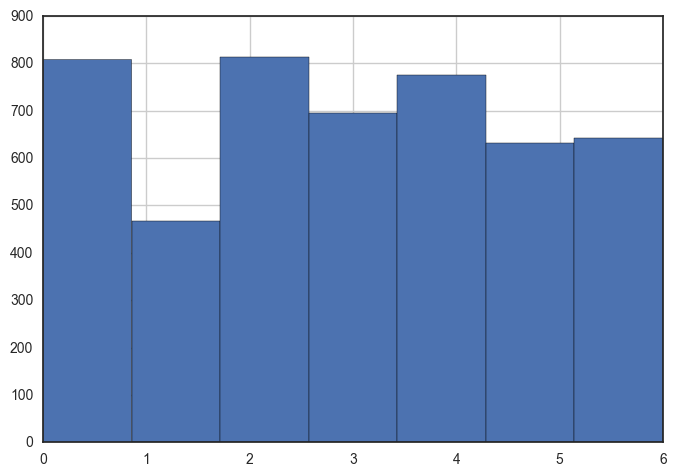

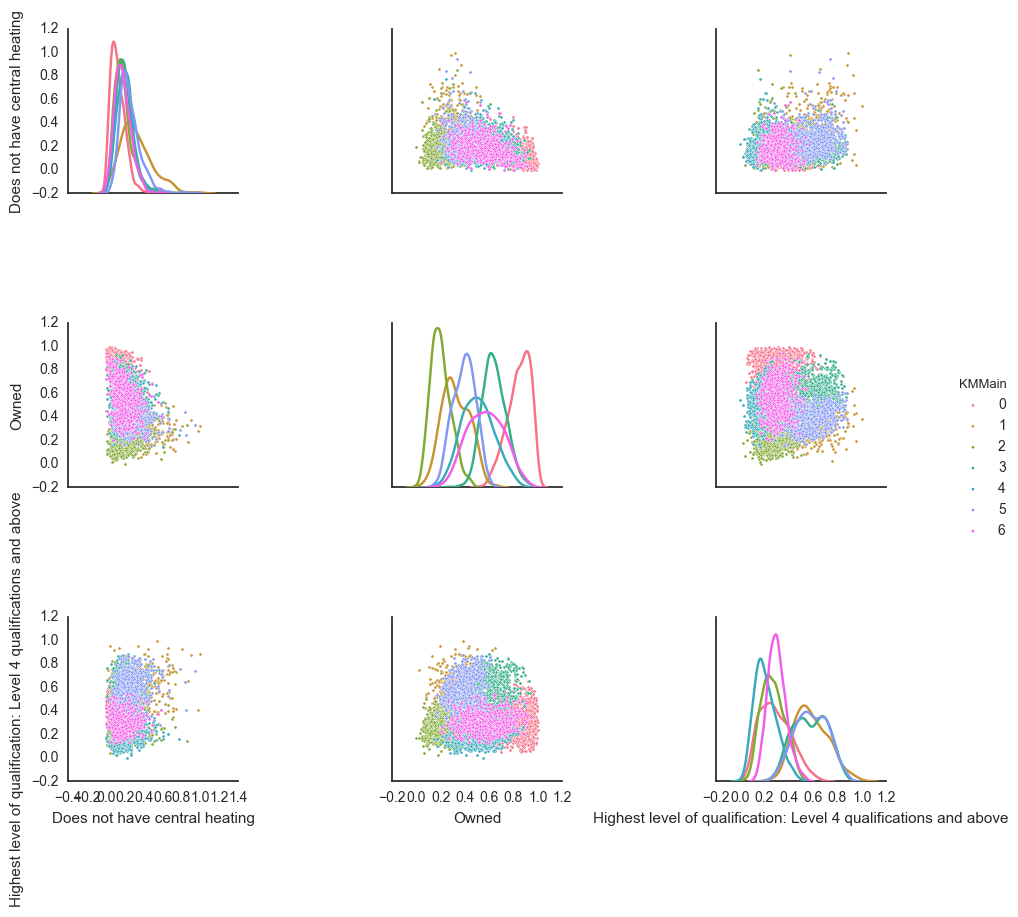

In [319]:
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
df.drop(list(df.columns[df.isnull().any().values].values), axis=1, inplace=True)

k=7
k_var = 'KMMain'
kmeans = KMeans(n_clusters=k).fit(df)

print(kmeans.labels_)

df[k_var] = pd.Series(kmeans.labels_, index=df.index)

# How are the clusters distributed?
df.KMMain.hist(bins=k)

# Going to be a bit hard to read
sns.pairplot(df, 
             vars=['Does not have central heating','Owned','Highest level of qualification: Level 4 qualifications and above'], 
             hue=k_var, markers=".", size=3, diag_kind='kde')

You can see that the outliers on the Group 1 and Not Classified LQ dimensions have been grouped into clusters. The other clusters have tended to cut through the bulk of the data, but if you look at the above map then you'll see that it has done a decent job of splitting the data sets into groups given that most of the data _isn't_ extreme.

### One More Thing...

There's just _one_ little problem: what assumption did I make when I started this _k_-means cluster analysis? It's a huge one, and it's one of the reasons that _k_-means clustering _can_ be problematic when used naively...

How did I pick the number of clusters?

### The Silhouette Plot

To try to make the process of selecting the number of clusters a little less arbitrary, the silhouette plot allows us to evaluate the 'quality' of the clustering outcome by examining the distance between each observation and the rest of the cluster. So to evaluate this in a systematic way, we want to do _multiple_ _k_-means passes at _multiple_ values of _k_ and then we can look at which gives the best results...

Let's try it for the range 3-7.

Cluster count: 3
('For k =', 3, 'The average silhouette_score is :', 0.44098849893222991)


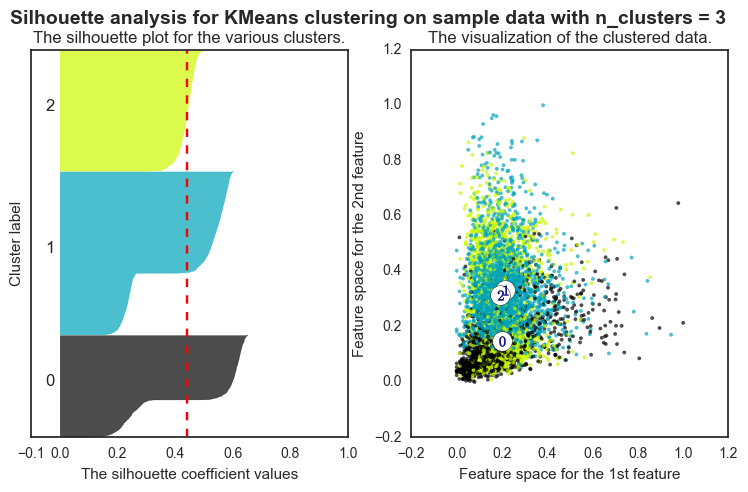

Cluster count: 4
('For k =', 4, 'The average silhouette_score is :', 0.47256757479915473)


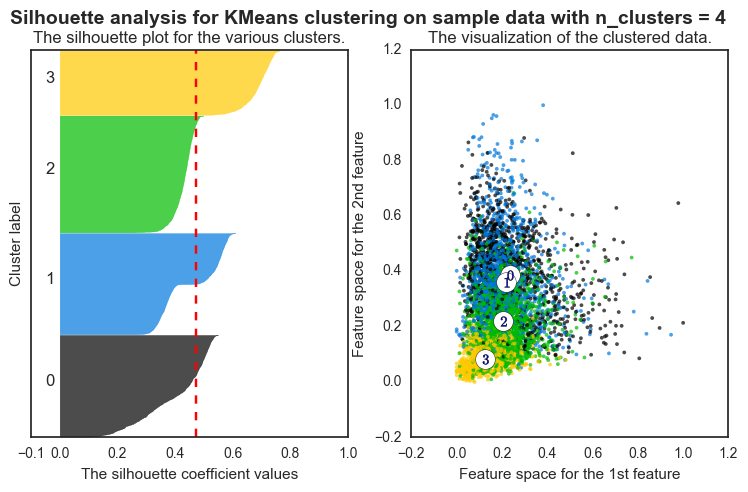

Cluster count: 5
('For k =', 5, 'The average silhouette_score is :', 0.47034401970159279)


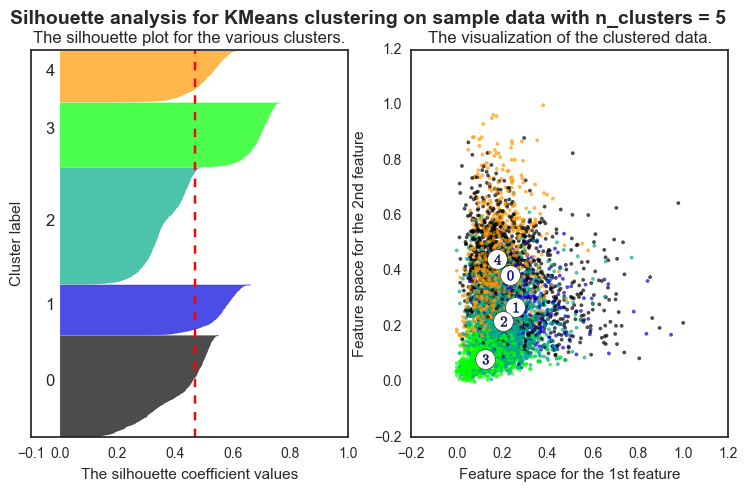

Cluster count: 6
('For k =', 6, 'The average silhouette_score is :', 0.49188522029175485)


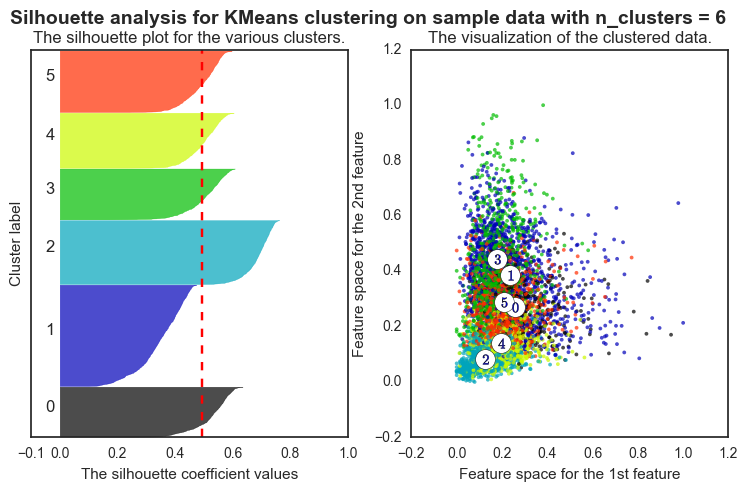

Cluster count: 7
('For k =', 7, 'The average silhouette_score is :', 0.51172363409502009)


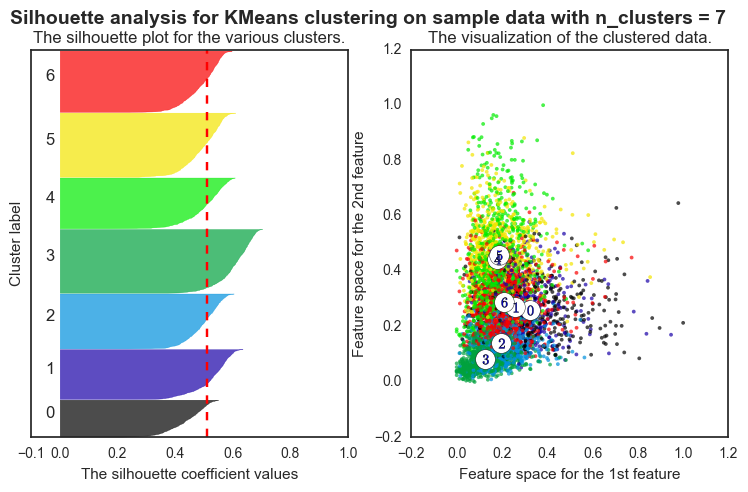

In [321]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

for k in range(3,8):
    # Debugging
    print("Cluster count: " + str(k))
    
    #############
    # Do the clustering using the main columns
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(df)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(df, cluster_labels)
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)
    
    # Calculate the silhouette values
    sample_silhouette_values = silhouette_samples(df, cluster_labels)
    
    #############
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, df.shape[0] + (k + 1) * 10])
    
    y_lower = 10
    
    # For each of the clusters...
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = cm.spectral(cluster_labels.astype(float) / k)
    ax2.scatter(df[df.columns[0]], df[df.columns[1]], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

    plt.show()

### Interpreting the Results

The results above suggest that 4 clusters is probably 'best' -- but note that that's only if we don't have any kind of underlying _theory_, other _empirical evidence_, or just a _reason_ for choosing a different value... Again, we're now getting in areas where _your judgement_ and your ability to _communicate your rationale_ to readers is the key thing. 

Let's repeat the 4-cluster process and then map it.

In [327]:
gdf.set_index('lsoa11cd', drop=True, inplace=True)
gdf.index.Name = None
gdf.head()

,geometry,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths
lsoa11cd,,,,,,
E01000001,"POLYGON ((532106.8939689073 182011.4758723566,...",City of London 001A,City of London 001A,1,"133,320.77","2,291.85"
E01000002,"POLYGON ((532748.6236845022 181787.1247154782,...",City of London 001B,City of London 001B,2,"226,191.27","2,433.96"
E01000003,"POLYGON ((532136.9496997485 182198.3681596624,...",City of London 001C,City of London 001C,3,"57,302.97","1,142.36"
E01000005,"POLYGON ((533809.7647333888 180767.9679630951,...",City of London 001E,City of London 001E,4,"190,738.76","2,167.87"
E01000006,"POLYGON ((545123.9250508548 184315.1024676577,...",Barking and Dagenham 016A,Barking and Dagenham 016A,5,"144,195.85","1,935.51"


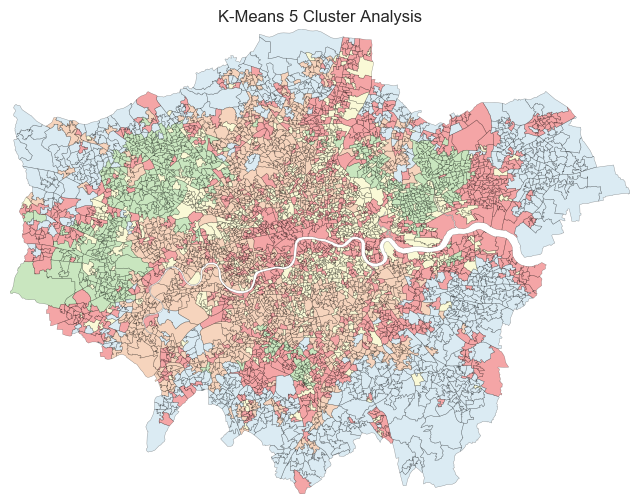

In [337]:
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
df.drop(list(df.columns[df.isnull().any().values].values), axis=1, inplace=True)

k_pref = 5
kmeans = KMeans(n_clusters=k_pref).fit(df)
df[k_var] = pd.Series(kmeans.labels_, index=df.index)

sdf = gdf.join(df, how='inner')

from pysal.contrib.viz import mapping as maps

# Where will our shapefile be stored
shp_link = os.path.join('data','lsoas.shp')

# Save it!
sdf.to_file(shp_link)

# And now re-load the values from the DBF file 
# associated with the shapefile.
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col(k_var))

types = ['unique_values']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title='K-Means ' + str(k_pref) + ' Cluster Analysis', figsize=(8,6))

To make sense of whether this is a 'good' result, you might want to visit [datashine](http://datashine.org.uk/#table=QS607EW&col=QS607EW0050&ramp=RdYlGn&layers=BTTT&zoom=10&lon=-0.1751&lat=51.4863) or think back to last year when we examined the NS-SeC data. 

You could also think of ways of plotting how these groups differ. For instance...

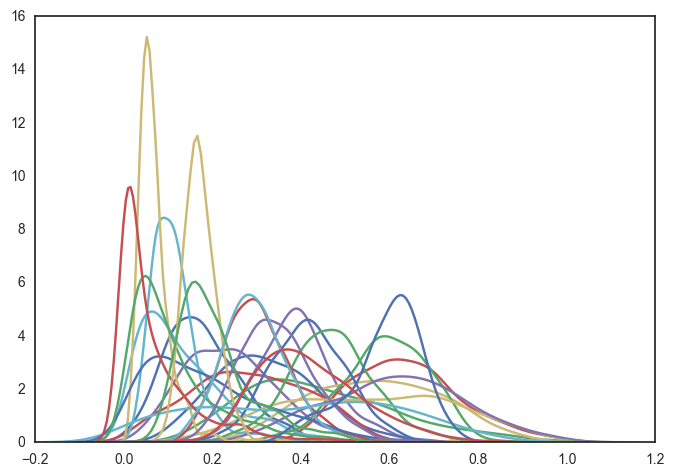

In [343]:
k1 = df[df.KMMain==0]
for c in df.columns:
    sns.distplot(k1[c], hist=False, kde=True, axlabel='')

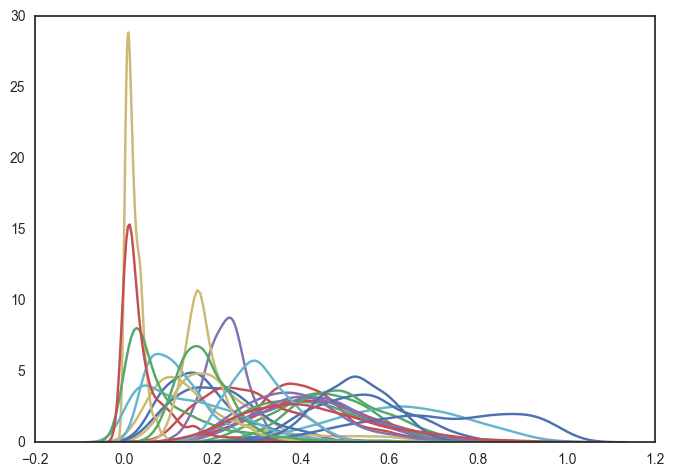

In [342]:
k1 = df[df.KMMain==1]
for c in df.columns:
    sns.distplot(k1[c], hist=False, kde=True, axlabel='')

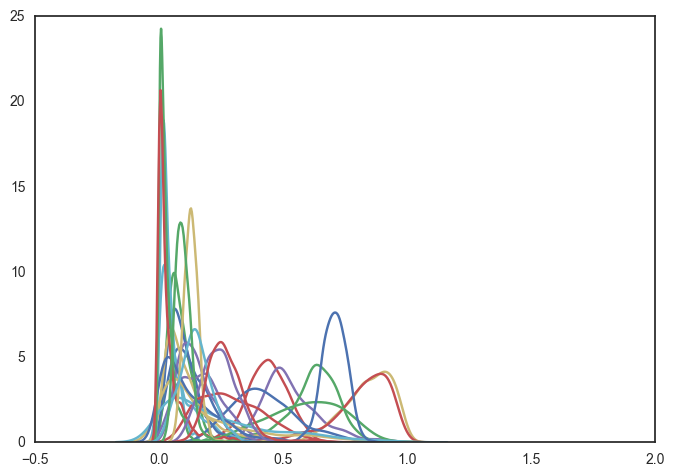

In [345]:
k1 = df[df.KMMain==2]
for c in df.columns:
    sns.distplot(k1[c], hist=False, kde=True, axlabel='')

### _Really, really important _

Now would be a good time to think about _how_ standardisation and normalisation would have changed your results... and you might want to test whether applying these in a 'stronger' format (e.g. sklearn's `robust_rescale` and scipy's `boxcox`) help or hinder your analysis!

## DBScan

Of course, as we've said above _k_-means is just one way of clustering, DBScan is another. Unlike _k_-means, we don't need to specify the number of clusters in advance. Which sounds great, but we still need to specify _other_ parameters and these can have a huge impact on our results!

In [349]:
# Quick sanity check in case something hasn't
# run successfully -- these muck up k-means
df.drop(list(df.columns[df.isnull().any().values].values), axis=1, inplace=True)

from sklearn.cluster import DBSCAN

dbs = DBSCAN().fit(df)

df['DBSCAN'] = pd.Series(dbs.labels_)

df.DBSCAN.value_counts()

Series([], Name: DBSCAN, dtype: int64)

In [ ]:
sdf = gdf.join(df)

sdf.sample(5)[['GeoCode','KMMain','DBSCAN']]

In [ ]:
from pysal.contrib.viz import mapping as maps

# Where will our shapefile be stored
shp_link = os.path.join('data','lsoas.shp')

# Save it!
sdf.to_file(shp_link)

# And now re-load the values from the DBF file 
# associated with the shapefile.
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col('DBSCAN'))

types = ['unique_values']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title='DBSCAN Cluster Analysis', figsize=(8,6))

So, rather less useful than we might have initially hoped... let's look at those parameters again.

In [ ]:
help(DBSCAN)

In [ ]:
dbs = DBSCAN().fit(dflq[main_cols])

dflq['DBSCAN'] = pd.Series(dbs.labels_)

dflq.DBSCAN.value_counts()

## Self-Organising Maps



In [ ]:
import clusterpy

lsoas = clusterpy.importArcData(os.path.join('data','lsoas-subset'))

In [ ]:
lsoas.cluster('som', ['Group1LQ','Group2LQ','Group3LQ','Group4LQ','Group5LQ','Group6LQ','Group7LQ','Group8LQ','GroupNCLQ'], 9, wType='queen', dissolve=1)

In [ ]:
lsoas.outputCluster

In [ ]:
help(lsoas.save)

In [ ]:
#sdf['som'] = pd.Series()
#help(lsoas.results)
lsoas.outputCluster
#lsoas.outputCluster['som_20170121134016']['SOMOutputLayer']
#for r in lsoas.outputCluster['som_20170121134016']['r2a']:
#    print(r)
#pd.Series(lsoas.outputCluster['som_20170121134016']['r2a'], index=sdf.index)
#sdf.to_file(os.path.join('data','lsoas-subset-som'))

In [ ]:
help(cpy.exportArcData)